In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [5]:
%pip install keras

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from keras.optimizers import RMSprop
#from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
balance_data = pd.read_csv("C:\Data Science\Projects\Hate speach\HateSpeechDatasetBalanced.csv\HateSpeechDatasetBalanced.csv")


In [10]:
balance_data.head(5)


,Content,Label
0,denial of normal the con be asked to comment on tragedies an emotional retard,1
1,just by being able to tweet this insufferable bullshit proves trump a nazi you vagina,1
2,that is retarded you too cute to be single that is life,1
3,thought of a real badass mongol style declaration of war the attackers capture a citizen of the soon to be,1
4,afro american basho,1


<Axes: xlabel='Label', ylabel='count'>

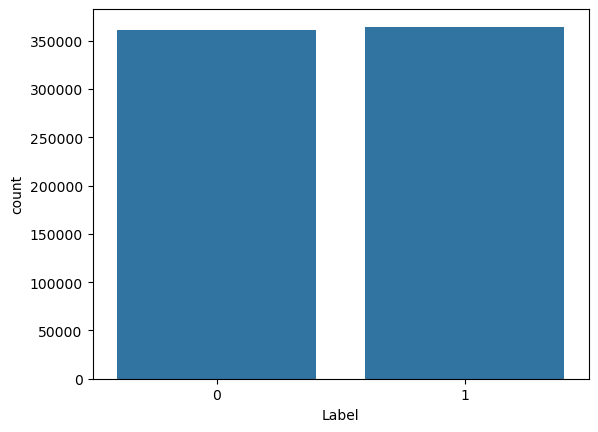

In [11]:
sns.countplot(x='Label',data =balance_data)

In [12]:
balance_data.shape

(726119, 2)

In [13]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [14]:
x = balance_data['Content']
y = balance_data['Label']

In [15]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

544589 544589
181530 181530


In [16]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [17]:
len(x_test)

181530

In [70]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [71]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [72]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Build the model with a dummy input shape
model.build(input_shape=(None, max_len))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()

c:\Users\asus\anaconda\envs\hatespeach\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 300, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,701 (24.76 MB)

 Trainable params: 6,491,701 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Define callbacks
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# starting model training
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=1,
                    validation_split=0.2, callbacks=[stop, checkpoint])

3404/3404 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8016 - loss: 0.4217
Epoch 1: val_loss improved from inf to 0.32673, saving model to model.h5


3404/3404 ━━━━━━━━━━━━━━━━━━━━ 3075s 902ms/step - accuracy: 0.8016 - loss: 0.4217 - val_accuracy: 0.8524 - val_loss: 0.3267


In [75]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [76]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

5673/5673 ━━━━━━━━━━━━━━━━━━━━ 187s 33ms/step - accuracy: 0.8548 - loss: 0.3242


In [77]:
lstm_prediction = model.predict(test_sequences_matrix)

5673/5673 ━━━━━━━━━━━━━━━━━━━━ 191s 34ms/step


In [78]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

In [79]:
print(confusion_matrix(y_test,res))

[[73610 16481]
 [ 9898 81541]]


In [80]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
# Let's save the mdoel.
model.save("model.h5")

In [82]:
import keras

In [83]:
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [94]:
# Let's test our model on custom data.
test = 'fuck you'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")
    

fuck you
fuck you
['fuck']
[[83]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
pred [[0.6336659]]
hate and abusive
